# Regularization
Regularization is the name for a technique developed at different times and in different ways in statistics and machine learning for improving the predictive quality of a model. The idea is to make a model simpler than it might otherwise be by either making the coefficients small, making the coefficients zero, or perhaps some combination of both at the same time. Regularization is implemented by default in sklearn's linear models.

In [1]:
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

Let's generate some sample data. 100000 observations, 50 features, only 5 of which matter, 7 of which are redundant, split among 2 classes for classification.

In [2]:
X, y = make_classification(n_samples=100000, 
                           n_features=50, 
                           n_informative=5, 
                           n_redundant=7, 
                           n_classes=2,
                          random_state=2)

When building linear models, it's a good idea to standarize all of your predictors (mean at zero, variance 1). 

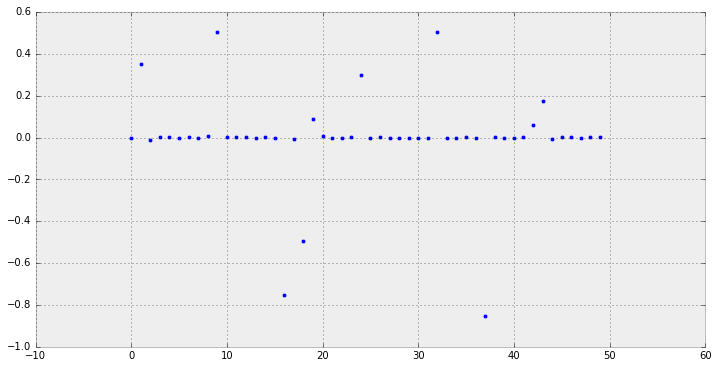

In [3]:
figsize(12, 6)
plt.scatter(range(50), np.mean(X, axis=0));

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

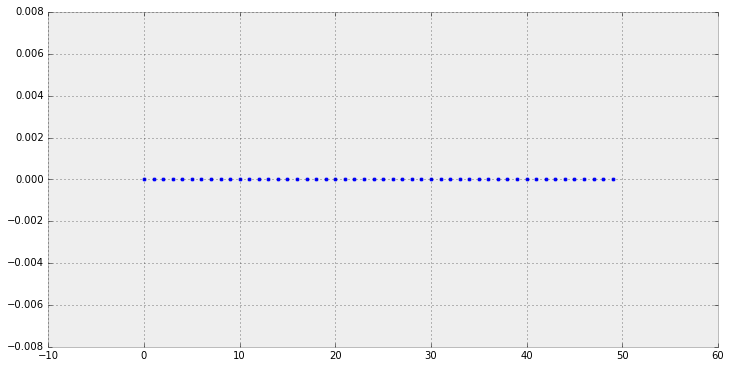

In [5]:
figsize(12, 6)
plt.scatter(range(50), np.mean(X, axis=0));

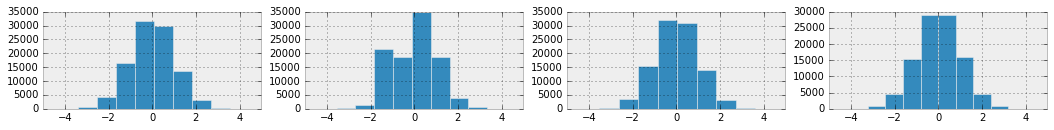

In [6]:
# nice normal looking predictors
figsize(18, 8)
ax = plt.subplot(441)
plt.hist(X[:, 0]);
    
ax = plt.subplot(442)
plt.hist(X[:, 1]);

ax = plt.subplot(443)
plt.hist(X[:, 2]);

ax = plt.subplot(444)
plt.hist(X[:, 3]);

In [7]:
# multicollinearity
correlations = np.corrcoef(X, rowvar=0)

corrpairs = {}
for i in range(50):
    for j in range(i+1, 50, 1):
        if correlations[i, j] > 0.25:
            print(i, j, correlations[i,j])
            corrpairs[(i,j)] = correlations[i,j]

1 9 0.726949350643
1 13 0.606579927635
1 18 0.255835020937
1 19 0.810447437735
1 24 0.380486016381
1 26 0.42502579766
1 43 0.655921269696
9 19 0.456310674759
9 26 0.288312680355
9 43 0.616191069381
13 16 0.376803964405
13 18 0.425279003734
13 19 0.674599317708
13 24 0.389994379041
16 18 0.778885368515
16 37 0.729783380122
19 24 0.451426884508
19 26 0.277160403695
19 43 0.687377233213
24 26 0.544026647404
24 42 0.311639400533
24 43 0.486457420514
26 43 0.794905528454
32 42 0.311153071282
37 42 0.392571300964


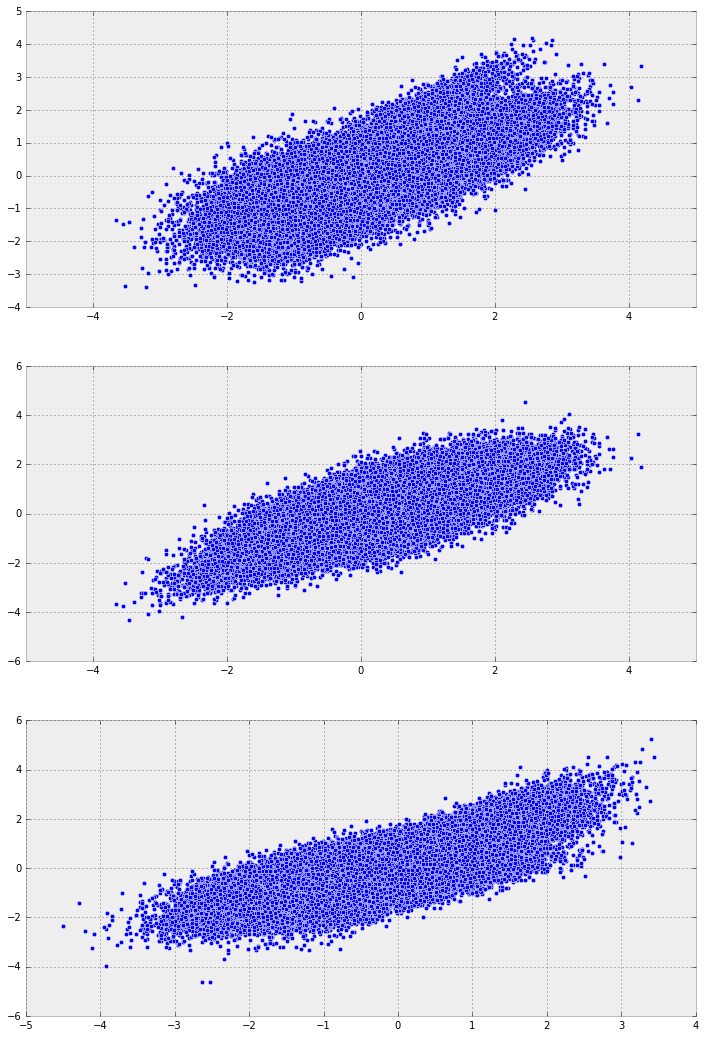

In [8]:
# plot is slow - 1 min or more
figsize(12, 18)

plt.subplot(311)
plt.scatter(X[:, 16], X[:, 37])

plt.subplot(312)
plt.scatter(X[:, 16], X[:, 18])

plt.subplot(313)
plt.scatter(X[:, 26], X[:, 43]);

Let's perform a train-test split for cross-validation.

In [9]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=0)

Next let's build a model using the default parameters and look at several different measures of performance.

In [10]:
default_model = LogisticRegression(random_state=0).fit(Xtr,ytr)  # instantiate and fit
pred = default_model.predict(Xte)  # make predictions
print('Accuracy: %s\n' % default_model.score(Xte, yte))  
print(classification_report(yte, pred)) 
print('Confusion Matrix:\n\n %s\n' % confusion_matrix(yte, pred)); 

Accuracy: 0.8397

             precision    recall  f1-score   support

          0       0.85      0.83      0.84      9912
          1       0.83      0.85      0.84     10088

avg / total       0.84      0.84      0.84     20000

Confusion Matrix:

 [[8179 1733]
 [1473 8615]]



In the sklearn implementation, this default model <i>is</i> a regularized model, using $\mathcal{l}2$ regularization with $C = 1$. That is, the cost function to be minimized is $$-\frac{1}{n}\sum_{i=1}^n[y_i\log(p_i) - (1-y_i)\log(y_i - p_i)]+\frac{1}{C}\cdot\sum_{j=1}^m w_j^2.$$ Here, $y_i$ is the $i^{th}$ response (target), $p_i$ is the predicted probability of that target, and $w_j$ are the coefficients of the linear model. In a traditional statistical implementation, the second sum wouldn't be there as it biases the model. This is the regularization.

There is no reason to believe that $C = 1$ is the ideal choice; it may be better to increase or decrease $C$. One way to search for better values by doing a grid search over a set of possible values for $C$, assessing the best choice using cross-validation.

In [11]:
cs = [10**(i+1) for i in range(2)] + [10**(-i) for i in range(5)]  # create a list of C's
print(cs)

[10, 100, 1, 0.1, 0.01, 0.001, 0.0001]


In [12]:
lm = LogisticRegression(random_state=0) 

grid = GridSearchCV(estimator=lm, 
                    param_grid=dict(C=cs), 
                    scoring='accuracy',
                    verbose=1,
                    cv=5, 
                    n_jobs=-1,  # parallelize over all cores
                    refit=True)  # instatiate the grid search (note model input)

grid.fit(Xtr, ytr)  # fit 
print("Best score: %s" % grid.best_score_)
print("Best choice of C: %s" % grid.best_estimator_.C)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   10.6s finished


Best score: 0.8416375
Best choice of C: 0.001


In [13]:
# change the metric
grid_prec = GridSearchCV(estimator=lm, 
                    param_grid=dict(C=cs), 
                    scoring='precision',
                    verbose=1,
                    cv=5, 
                    n_jobs=-1,  # parallelize over all cores
                    refit=True)  # instatiate the grid search (note model input)

grid_prec.fit(Xtr, ytr)  # fit 
print("Best score: %s" % grid_prec.best_score_)
print("Best choice of C: %s" % grid_prec.best_estimator_.C)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   10.2s finished


Best score: 0.831911995219
Best choice of C: 0.1


In [14]:
# change the metric
grid_auc = GridSearchCV(estimator=lm, 
                    param_grid=dict(C=cs), 
                    scoring='roc_auc',
                    verbose=1,
                    cv=5, 
                    n_jobs=-1,  # parallelize over all cores
                    refit=True)  # instatiate the grid search (note model input)

grid_auc.fit(Xtr, ytr)  # fit 
print("Best score: %s" % grid_auc.best_score_)
print("Best choice of C: %s" % grid_auc.best_estimator_.C)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   10.1s finished


Best score: 0.915052639594
Best choice of C: 0.01


In [15]:
grid_preds = grid.predict(Xte)  
print('Accuracy: %s\n' % accuracy_score(grid.predict(Xte), yte))
print(classification_report(yte, grid_preds))
print('Confusion Matrix:\n\n %s\n' % confusion_matrix(yte, grid_preds));

Accuracy: 0.8396

             precision    recall  f1-score   support

          0       0.85      0.82      0.84      9912
          1       0.83      0.86      0.84     10088

avg / total       0.84      0.84      0.84     20000

Confusion Matrix:

 [[8150 1762]
 [1446 8642]]



In [16]:
grid.best_estimator_.coef_

array([[ -1.94881362e-03,   6.11894799e-01,   5.56016366e-03,
          9.66391259e-03,  -3.37593417e-03,  -2.84746983e-03,
          5.43636937e-03,   1.05682075e-02,   1.27804594e-02,
          3.79970966e-01,   1.32455604e-03,   7.75931819e-03,
          6.03182136e-03,   7.69719240e-01,  -4.38522147e-03,
         -9.10312768e-03,   3.89346423e-01,  -6.07929488e-03,
          1.31749101e-01,   7.11110748e-01,  -3.30808982e-04,
         -9.19102612e-03,  -2.18644108e-03,  -1.24054210e-02,
          2.09419123e-01,   4.55561566e-03,  -3.91681865e-01,
          9.15080966e-03,  -7.85568577e-05,   3.33015315e-03,
          1.74126013e-02,   1.42947252e-02,  -2.87393846e-01,
         -4.92830888e-03,   5.10965364e-03,   6.32300394e-03,
         -1.04355603e-02,   1.28024019e-01,   1.72433861e-03,
          7.28022705e-03,   3.71547934e-03,   3.40682893e-03,
         -9.82192133e-02,   7.91444907e-02,   1.13302578e-02,
         -2.20890918e-03,   1.70834618e-02,   1.40809490e-02,
        

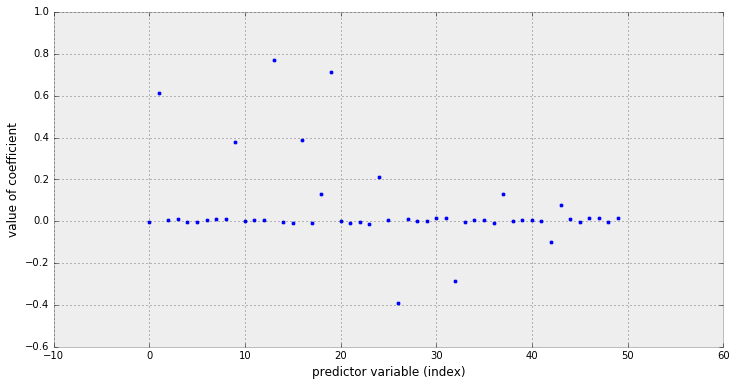

In [17]:
figsize(12, 6)
plt.scatter(range(grid.best_estimator_.coef_.shape[1]),
            grid.best_estimator_.coef_)
plt.ylabel('value of coefficient')
plt.xlabel('predictor variable (index)');

Another way to do this is with the 'LogisticRegressionCV' function. This is a logistic regression function built with tuning $C$ via cross-validation in mind. This time, we'll set the penalty to $\mathcal{l}1$, we'll let python pick 10 possible $C$'s, we'll use all cores on my machine ('n_jobs=-1'), and we'll use the liblinear solver (which is the only one of the three possible choice which can optimize with the l1 penalty). The $\mathcal{l}1$ penalty is $$-\frac{1}{n}\sum_{i=1}^n[y_i\log(p_i) - (1-y_i)\log(y_i - p_i)]+\frac{1}{C}\cdot\sum_{j=1}^m |w_j|.$$ This will take a minute or two to run.

In [18]:
cvmodel = LogisticRegressionCV(penalty='l1', 
                               Cs=10, 
                               n_jobs=-1,
                               verbose=1,
                               scoring='accuracy',
                               solver='liblinear')  # liblinear only for l1 penalty

In [19]:
# takes about a minute
cv_fit = cvmodel.fit(Xtr,ytr)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   59.0s finished


In [20]:
cvmodel.C_

array([ 0.00599484])

In [21]:
cvmodel.coef_  # now all very small, most effectively 0

array([[ 0.        ,  0.64766949,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.12835093,
         0.        ,  0.        ,  0.        ,  0.53989798,  0.        ,
         0.        ,  0.65691285,  0.        ,  0.        ,  1.4445903 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.39762551,  0.        ,  0.        ,  0.        ,
         0.00386294,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00242243,  0.        ,  0.        ,  0.00376126]])

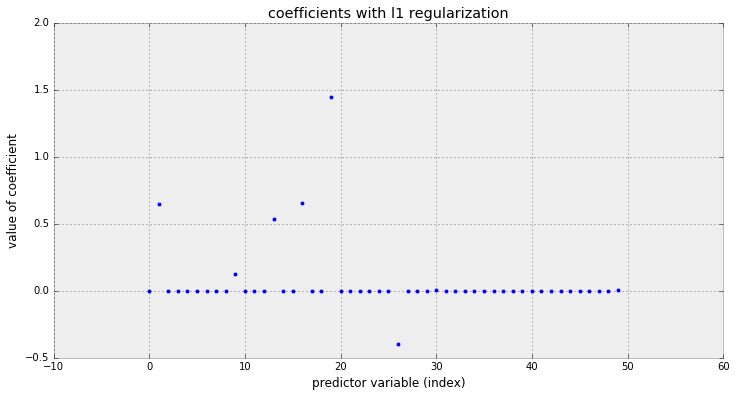

In [22]:
plt.scatter(range(cvmodel.coef_.shape[1]), cvmodel.coef_[0])
plt.ylabel('value of coefficient')
plt.xlabel('predictor variable (index)')
plt.title('coefficients with l1 regularization');

In [23]:
cv_preds = cvmodel.predict(Xte)
print(accuracy_score(cv_preds, yte))

0.841


In [24]:
tuned_cv_scores = cross_val_score(cv_fit, X, y, scoring='accuracy',n_jobs=-1, verbose=2)

[CV] no parameters to be set .........................................
[CV] no parameters to be set .........................................


/Users/jwj2/anaconda/envs/snowflakes/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1583: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for label in iter_labels


[CV] no parameters to be set .........................................


/Users/jwj2/anaconda/envs/snowflakes/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1583: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for label in iter_labels
/Users/jwj2/anaconda/envs/snowflakes/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1583: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  for label in iter_labels
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV] ................................ no parameters to be set - 1.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV] ................................ no parameters to be set - 1.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][CV] ................................ no parameters to be set - 1.3min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


In [25]:
print(tuned_cv_scores)
print(np.mean(tuned_cv_scores))

[ 0.84049319  0.84231842  0.84345843]
0.842090015968


In [26]:
default_cv_scores = cross_val_score(default_model.fit(Xtr, ytr), X, y, scoring='accuracy',n_jobs=-1, verbose=2)

[CV] no parameters to be set .........................................
[CV] no parameters to be set .........................................
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.9s
[CV] ................................ no parameters to be set -   1.0s
[CV] ................................ no parameters to be set -   1.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


In [27]:
print(default_cv_scores)
print(np.mean(default_cv_scores))

[ 0.83890322  0.84084841  0.84261843]
0.840790018868


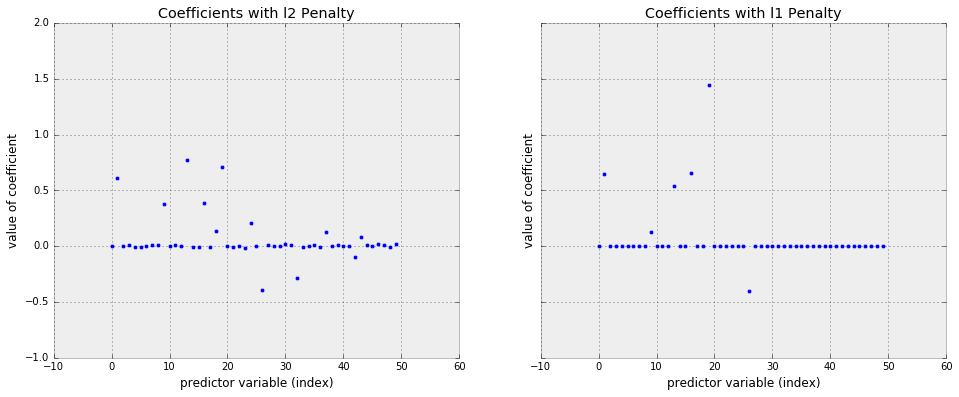

In [28]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(16, 6))

ax[0].scatter(range(grid.best_estimator_.coef_.shape[1]),
            grid.best_estimator_.coef_)
ax[0].set_ylabel('value of coefficient')
ax[0].set_xlabel('predictor variable (index)')
ax[0].set_title('Coefficients with l2 Penalty')

ax[1].scatter(range(cvmodel.coef_.shape[1]), cvmodel.coef_[0])
ax[1].set_ylabel('value of coefficient')
ax[1].set_xlabel('predictor variable (index)')
ax[1].set_title('Coefficients with l1 Penalty');

In [29]:
trivial = np.isclose(cvmodel.coef_, np.zeros(shape=cvmodel.coef_.shape)).flatten()
nontrivial = []
for i in range(len(trivial)):
    if not trivial[i]:
        nontrivial.append(i)

In [30]:
nontrivial

[1, 9, 13, 16, 19, 26, 30, 46, 49]

In [31]:
final = LogisticRegression(C=cvmodel.C_[0], penalty='l1', solver='liblinear').fit(X[:, nontrivial], y)

In [32]:
# thanks StackOverflow! 
# see http://stackoverflow.com/questions/36373266/change-in-running-behavior-of-sklearn-code-between-laptop-and-desktop/37259431 
import warnings
warnings.filterwarnings("ignore")

final_cv_scores = cross_val_score(final, X[:, nontrivial], y, scoring='accuracy', n_jobs=-1)

In [33]:
print(final_cv_scores)
print(np.mean(final_cv_scores))

[ 0.84049319  0.84240842  0.84348843]
0.842130016368


In [34]:
alt = cross_val_score(LogisticRegressionCV(penalty='l1', solver='liblinear', verbose=2, n_jobs=-1), X[:, nontrivial], y, scoring='accuracy')
print(alt)
print(np.mean(alt))

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished


[LibLinear]

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


[LibLinear][LibLinear][ 0.84049319  0.84237842  0.84345843]
0.842110016168


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished
